<p>
    <b>Name:</b> Florian Ries<br>
    <b>Matrikelnr.:</b> 571803<br>
    <b>Kurs:</b> Angewandte Programmierung MBB Köln
</p>

# NFL Big Data Bowl: Development of a generic Classification Model to predict a new 'First Down'

<h3>Data Source</h3>
<p><b>DATASET:</b> <a href="https://www.kaggle.com/c/nfl-big-data-bowl-2020/data?select=train.csv">Link to the dataset (Kaggle)</a> (https://www.kaggle.com/c/nfl-big-data-bowl-2020/data?select=train.csv)</p>
<p><b>SOURCE CODE:</b> <a href="https://gitlab.com/floriancph/football-predictor">Code available on GitLab</a> (https://gitlab.com/floriancph/football-predictor)</p>

# Table of Content

[Data Source](#Data-Source)
1. [Business Understanding](#1.-BUSINESS-UNDERSTANDING)
2. [Data Understanding & Data Preparation](#2.-DATA-UNDERSTANDING-&-DATA-PREPARATION)
3. [Modeling](#3.-MODELING)
4. [Evaluation](#4.-EVALUATION)
5. [Deployment](#5.-DEPLOYMENT)
6. [Attachment / Visualizations](#6.-ATTACHMENT-/-VISUALIZATIONS)

<h3>Structure of the Notebook derived from CRISP-DM life cycle</h3>
<img src="pic.jpeg" width=350 height=300 align="left" />

<h1>1. BUSINESS UNDERSTANDING</h1>
<h3>1.1 The Business Question</h3>
<h3><i>"Do I get a new <b>'First Down'</b> based on generic information available right before the snap?"</i></h3>
<p>The aim is to <b>train a generic model</b>, which can answer the question above and can be applied regardless of the Team and the individual players. The model should contain following input parameters:</p>
<li>The Quarter</li>
<li>The Yard Line and side of the field</li>
<li>Distance to the new First Down Maker</li>
<li>Number of current attempt</li>
<li>Number of defenders in the 'box'</li>

<p>The <b>output</b> should be a prediction, if a new First Down can be achieved based on the different Offensive Formations.</p>

<h3>1.2 About the dataset</h3>
<li>The dataset has <b>49 columns</b> and <b>~680 000 observations</b></li>
<li>It contains <b>22 observations for each play</b> (each for a player on the field)</li>


<h3>1.3 American Football rules in a nutshell</h3>
<li>American Football is about to <b>gain yards and score points</b> through touchdowns or field goals</li>
<li>The <b>Offense</b> of one team plays always against the Defense of the other team and has <b>4 attempts (Downs)</b> to gain 10 yards</li>
<li>Thus, accomplishing "First Downs" is very <b>important for the Offense</b> - while preventing it, is crucial for the Defense</li>
<li>This is how a football field looks like:</li>
<img src="https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F3258%2F820e86013d48faacf33b7a32a15e814c%2FIncreasing%20Dir%20and%20O.png?generation=1572285857588233&alt=media" height=100 />

<h1>2. DATA UNDERSTANDING & DATA PREPARATION</h1>

<h3>2.1 Data Import</h3>

In [1]:
# Imports
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
sns.set_style('darkgrid')
pd.set_option('max_columns', 100)

In [2]:
# Read CSV-file
df = pd.read_csv('../static/train.csv', low_memory=False)
df.shape

(682154, 49)

<p>Dataframe has 49 columns and 682154 rows</p>

In [3]:
# Get information about columns and their type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682154 entries, 0 to 682153
Data columns (total 49 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   GameId                  682154 non-null  int64  
 1   PlayId                  682154 non-null  int64  
 2   Team                    682154 non-null  object 
 3   X                       682154 non-null  float64
 4   Y                       682154 non-null  float64
 5   S                       682154 non-null  float64
 6   A                       682154 non-null  float64
 7   Dis                     682154 non-null  float64
 8   Orientation             682131 non-null  float64
 9   Dir                     682126 non-null  float64
 10  NflId                   682154 non-null  int64  
 11  DisplayName             682154 non-null  object 
 12  JerseyNumber            682154 non-null  int64  
 13  Season                  682154 non-null  int64  
 14  YardLine            

<h3>2.2 Missing Data</h3>

In [4]:
# Identify Missing Data (in %)
(df.isnull().sum()[df.isnull().sum() > 0].sort_values().to_frame('% of missing data')/len(df))*100

% of missing data
DefendersInTheBox           0.003225
Orientation                 0.003372
Dir                         0.004105
OffenseFormation            0.012900
Humidity                    0.903022
FieldPosition               1.261006
StadiumType                 6.111523
GameWeather                 8.820589
Temperature                 9.330151
WindSpeed                  13.467927
WindDirection              15.344922

<li><b><i>DefendersInTheBox</i> and <i>OffenseFormation</i> are important for generic prediction model</b></li>
<li><b>Missing data will now be replaced by <i>median</i> and <i>mode</i>:</b></li>

In [5]:
# Replace relevant missing data fields, which are needed for the prediction model later
median_DefendersInTheBox = df['DefendersInTheBox'].median()
mode_OffenseFormation = df['OffenseFormation'].mode().values[0] # Replace NULL values with most frequently used OF
df['DefendersInTheBox'].replace(np.nan, median_DefendersInTheBox, inplace=True)
df['OffenseFormation'].replace(np.nan, mode_OffenseFormation, inplace=True)

<h3>2.3 Data Understanding</h3>

In [6]:
# print number of plays with offense formations
# Note: Dividing by 22 due to the fact that for each play there are 22 rows (players) in the dataset
df['OffenseFormation'].value_counts().to_frame('Number of plays')/22

Number of plays
SINGLEBACK          13628.0
SHOTGUN              9389.0
I_FORM               6225.0
PISTOL                979.0
JUMBO                 677.0
WILDCAT                77.0
EMPTY                  31.0
ACE                     1.0

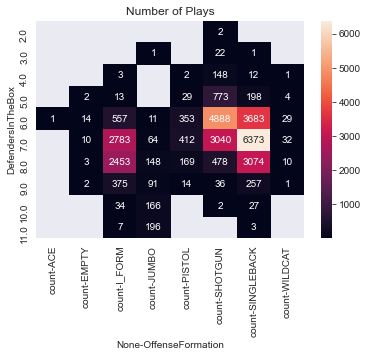

In [7]:
# Offense Formations vs. DefendersInTheBox and number of plays in the dataset
a = df[['OffenseFormation', 'DefendersInTheBox']].copy()
a['count'] = 1
group = a.groupby(['OffenseFormation', 'DefendersInTheBox'], as_index=False).sum()
group['count'] = group['count']/22
pivot = group.pivot(index='DefendersInTheBox', columns='OffenseFormation')
sns.heatmap(pivot, annot=True, fmt='g')
plt.title('Number of Plays');

<p><b>==> Most of the plays happen in the Shotgun or Singleback formation while 6-8 defenders in the box are usual</b></p>

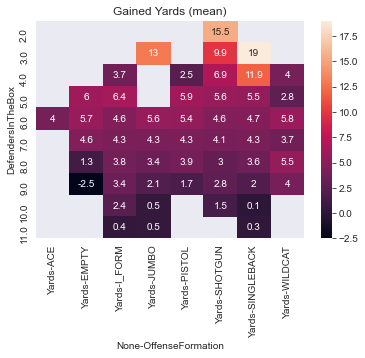

In [8]:
# Offense Formations vs. DefendersInTheBox and the gained Yards (mean)
a = df[['Yards', 'OffenseFormation', 'DefendersInTheBox']]
group = a.groupby(['OffenseFormation', 'DefendersInTheBox'], as_index=False).mean()
group['Yards'] = round(group['Yards'], 1)
pivot = group.pivot(index='DefendersInTheBox', columns='OffenseFormation')
sns.heatmap(pivot, annot=True, fmt='g')
plt.title('Gained Yards (mean)');

<h3>2.4 Feature Engineering</h3>
<p>To establish the generic prediction model, <b>some variables have to be changed, calculated and selected/prepared</b></p>

<p>Following Tasks will be done in the following cells:</p>
<ol type = "1">
    <li>Create <b>Dummy</b> Variables for <b>Offense Formations</b></li>
    <li>Get information on which <b>side of the field</b> the play happens (offense side or defense side)</li>
    <li>Calculate, if a new <b>First Down</b> was <b>achieved</b> by the Offense</li>
    <li><b>Select</b> relevant <b>features</b> for the Classification Model</li>
    <li><b>Drop duplicates</b> in the DataFrame (as there are 22 rows for each play and the model needs just one)</li>
    <li>Create <b>Training and Test data</b> (X_data, y_data)</li>
    <li><b>Scaling Data</b></li>
</ol>

In [9]:
# 1. create dummy-variables out of the existing Offense Formations and add them to the df
offense_dummy = pd.get_dummies(df['OffenseFormation'])
df = pd.concat([df, offense_dummy], axis=1)

In [10]:
# 2. create field to show if the Offense is on the own half (yes=1, no=0)
df['OFF_own_half'] = df['FieldPosition'] == df['PossessionTeam']
df['OFF_own_half'].replace(to_replace=[False, True], value=[0,1], inplace=True)

In [11]:
# 3. calculate gap to target line after the play (net_gain) 
# and determine if a first down was achieved (new1st_down)
### if <0    => no first down
### if >=0   => first down

df['net_gain'] = -df['Distance'] + df['Yards']
df['new1st_down'] = [1 if i>=0 else 0 for i in df['net_gain']]
df.head(2)

GameId          PlayId  Team      X      Y     S     A   Dis  \
0  2017090700  20170907000118  away  73.91  34.84  1.69  1.13  0.40   
1  2017090700  20170907000118  away  74.67  32.64  0.42  1.35  0.01   

   Orientation     Dir    NflId   DisplayName  JerseyNumber  Season  YardLine  \
0        81.99  177.18   496723    Eric Berry            29    2017        35   
1        27.61  198.70  2495116  Allen Bailey            97    2017        35   

   Quarter GameClock PossessionTeam  Down  Distance FieldPosition  \
0        1  14:14:00             NE     3         2            NE   
1        1  14:14:00             NE     3         2            NE   

   HomeScoreBeforePlay  VisitorScoreBeforePlay  NflIdRusher OffenseFormation  \
0                    0                       0      2543773          SHOTGUN   
1                    0                       0      2543773          SHOTGUN   

   OffensePersonnel  DefendersInTheBox  DefensePersonnel PlayDirection  \
0  1 RB, 1 TE, 3 WR                6.0  2 DL, 3 LB, 6 DB          left   
1  1 RB, 1 TE, 3 WR                6.0  2 DL, 3 LB, 6 DB          left   

                TimeHandoff                  TimeSnap  Yards PlayerHeight  \
0  2017-09-08T00:44:06.000Z  2017-09-08T00:44:05.000Z      8          6-0   
1  2017-09-08T00:44:06.000Z  2017-09-08T00:44:05.000Z      8          6-3   

   PlayerWeight PlayerBirthDate PlayerCollegeName Position HomeTeamAbbr  \
0           212      12/29/1988         Tennessee       SS           NE   
1           288      03/25/1989             Miami       DE           NE   

  VisitorTeamAbbr  Week           Stadium        Location StadiumType  \
0              KC     1  Gillette Stadium  Foxborough, MA     Outdoor   
1              KC     1  Gillette Stadium  Foxborough, MA     Outdoor   

         Turf     GameWeather  Temperature  Humidity WindSpeed WindDirection  \
0  Field Turf  Clear and warm         63.0      77.0         8            SW   
1  Field Turf  Clear and warm         63.0      77.0         8            SW   

   ACE  EMPTY  I_FORM  JUMBO  PISTOL  SHOTGUN  SINGLEBACK  WILDCAT  \
0    0      0       0      0       0        1           0        0   
1    0      0       0      0       0        1           0        0   

   OFF_own_half  net_gain  new1st_down  
0             1         6            1  
1             1         6            1

In [12]:
# 4. create list of features to be considered in the ML model
features1 = ['PlayId', 'Quarter', 'OFF_own_half', 'YardLine', 'Distance', 'Down', 
             'DefendersInTheBox', 
             'SINGLEBACK', 'SHOTGUN', 'I_FORM', 'PISTOL', 'JUMBO', 'WILDCAT', 'EMPTY', 
             'Yards', 'new1st_down']

In [13]:
# create new slice of the data frame with subset of features
data = df[features1].copy()
data.head(2)

PlayId  Quarter  OFF_own_half  YardLine  Distance  Down  \
0  20170907000118        1             1        35         2     3   
1  20170907000118        1             1        35         2     3   

   DefendersInTheBox  SINGLEBACK  SHOTGUN  I_FORM  PISTOL  JUMBO  WILDCAT  \
0                6.0           0        1       0       0      0        0   
1                6.0           0        1       0       0      0        0   

   EMPTY  Yards  new1st_down  
0      0      8            1  
1      0      8            1

In [14]:
# 5. drop duplicates in the rows - based on PlayId
data.drop_duplicates(subset=['PlayId'], inplace=True)
data.head(2)

PlayId  Quarter  OFF_own_half  YardLine  Distance  Down  \
0   20170907000118        1             1        35         2     3   
22  20170907000139        1             1        43        10     1   

    DefendersInTheBox  SINGLEBACK  SHOTGUN  I_FORM  PISTOL  JUMBO  WILDCAT  \
0                 6.0           0        1       0       0      0        0   
22                6.0           0        1       0       0      0        0   

    EMPTY  Yards  new1st_down  
0       0      8            1  
22      0      3            0

In [15]:
# Create feature and target dataset
X_data = data.drop(columns=['PlayId', 'new1st_down', 'Yards'], axis=1).values # delete target column
y_data = data['new1st_down'].values # select target column
X_data[:2]

array([[ 1.,  1., 35.,  2.,  3.,  6.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  1., 43., 10.,  1.,  6.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])

In [16]:
# 6. Create train & test datasets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.30, random_state=0)
print("number of test samples :", X_test.shape[0])
print("number of training samples:", X_train.shape[0])

number of test samples : 9303
number of training samples: 21704


In [17]:
X_train[:1]

array([[ 4.,  1., 32.,  2.,  2.,  7.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]])

In [18]:
# 7. Apply feature scaling to normalize data using StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.astype(float))
X_test = scaler.transform(X_test.astype(float))
X_train[:1]

array([[ 1.30073983,  0.88700543,  0.28225124, -1.65734209,  0.7148185 ,
         0.09195711, -0.88717127, -0.6585916 ,  1.99706749, -0.17861201,
        -0.15038586, -0.04994223, -0.03185383]])

<h1>3. MODELING</h1>
<p>In the modeling step, a <b>logistic regression model</b> will be trained and tested and then <b>compared with a decision tree</b> classification model</p>

<h3>3.1 Logistic Regresssion</h3>

In [19]:
# Train & Test Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

LR = LogisticRegression().fit(X_train, y_train)
yhat_LR = LR.predict(X_test)
accuracy_LR = metrics.accuracy_score(yhat_LR, y_test)

print(f'Accuracy of the model: {round(accuracy_LR, 4)}')

Accuracy of the model: 0.8319


<h3>3.2 Decision Tree</h3>

In [20]:
# Train & Test Decision Tree
from sklearn import tree
from sklearn.model_selection import GridSearchCV

In [21]:
decision_tree = tree.DecisionTreeClassifier()
p = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
     'class_weight': ['balanced', None]}

k = 3

clm_tree = GridSearchCV(decision_tree, p, cv = k)
clm_tree.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'class_weight': ['balanced', None],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'splitter': ['best', 'random']})

In [22]:
pd.DataFrame(clm_tree.cv_results_).sort_values(by = ['rank_test_score']).head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
40       0.012455      0.000086         0.001478        0.000044   
62       0.023843      0.000517         0.001963        0.000432   
42       0.014425      0.000258         0.001537        0.000020   
58       0.016267      0.001341         0.001784        0.000241   
44       0.016843      0.000300         0.001623        0.000054   

   param_class_weight param_criterion param_max_depth param_splitter  \
40               None            gini               4           best   
62               None         entropy               6           best   
42               None            gini               5           best   
58               None         entropy               4           best   
44               None            gini               6           best   

                                               params  split0_test_score  \
40  {'class_weight': None, 'criterion': 'gini', 'm...           0.825708   
62  {'class_weight': None, 'criterion': 'entropy',...           0.824879   
42  {'class_weight': None, 'criterion': 'gini', 'm...           0.823912   
58  {'class_weight': None, 'criterion': 'entropy',...           0.825432   
44  {'class_weight': None, 'criterion': 'gini', 'm...           0.824464   

    split1_test_score  split2_test_score  mean_test_score  std_test_score  \
40           0.817830           0.823749         0.822429        0.003349   
62           0.819627           0.821952         0.822153        0.002149   
42           0.818798           0.823472         0.822061        0.002314   
58           0.816586           0.823749         0.821922        0.003835   
44           0.817277           0.821537         0.821093        0.002951   

    rank_test_score  
40                1  
62                2  
42                3  
58                4  
44                5

In [23]:
yhat_tree = clm_tree.predict(X_test)
accuracy_tree = metrics.accuracy_score(yhat_tree, y_test)
print(f'Accuracy of the model: {round(accuracy_tree, 4)}')

Accuracy of the model: 0.8315


<h1>4. EVALUATION</h1>
<p>This chapter evaluates the created models</p>

In [24]:
# Create an Evaluation Function for both models
from sklearn import metrics
def evaluation(yhat, y_test):
    print('+++ Model Evaluation Report +++')
    print(f'Accuracy-Score: {metrics.accuracy_score(yhat, y_test)}')
    print('CONFUSION MATRIX')
    plt.figure(figsize=(8,3))
    sns.heatmap(metrics.confusion_matrix(y_test, yhat), annot=True, fmt='g')
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values');

<h3>4.1 Evaluate Logistic Regression</h3>

+++ Model Evaluation Report +++
Accuracy-Score: 0.8318821885413308
CONFUSION MATRIX


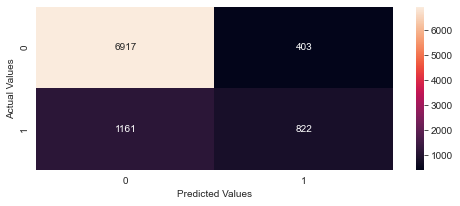

In [25]:
evaluation(yhat_LR, y_test)

<h3>4.2 Evaluate Decision Tree</h3>

+++ Model Evaluation Report +++
Accuracy-Score: 0.8314522197140707
CONFUSION MATRIX


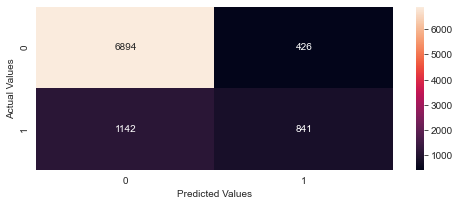

In [26]:
evaluation(yhat_tree, y_test)

<h1>5. DEPLOYMENT</h1>

<p>After the model-training and evaluation, the model(s) can be used in e.g. Websites, Apps, etc. to support decision making in real life. In this specific case, an Offensive Coordinator could use the model in order to make quick and data-driven decisions. The WebApp should act as a "digital Offensive Coordinator" and should recommend which Offense Formation is in the individual situation most promising for a new First Down.</p>

In [27]:
# Export Logistic Regression Model
# import pickle as pkl

In [28]:
# Export trained model into WebApp directory
# pkl.dump(LR, open('../static/model.p', 'wb'))
# pkl.dump(scaler, open('../static/scaler.sav', 'wb'))

<p><b>The WebApp will use the logistic Regression Model in order to predict the likelihood of a new first down for the Offsense. It also shows similar plays to the generic information provided by the user</b></p>

<p>Following data exports are needed</p>
<li>Dataset for Similarity check (similarity_df.csv): Based on the information provided by the user, the similarity to other plays should be calculated</li>
<li>All plays and IDs (data.csv): Dataset with all plays and related IDs for identification</li>
<li>Whole Training dataset (train.csv): In order to visualize the play, all the information of the players are necessary</li>

In [29]:
# Data Export for WebApp
# similarity_df = data.drop(['PlayId', 'SINGLEBACK', 'SHOTGUN', 'I_FORM', 'PISTOL', 'JUMBO', 'WILDCAT', 'EMPTY', 'Yards', 'new1st_down'], axis=1)
# similarity_df.to_csv('../static/similarity_df.csv')
# data.to_csv('../static/data.csv')

<h3>The WebApp is deployed on AWS via CI/CD Pipeline using Docker and can be tested using the link below</h3>
<p>(There was not much time spent on Application Robustness, so please be careful :D )</p>
<h3><a href="http://ec2-54-93-241-221.eu-central-1.compute.amazonaws.com:5000/" target="_blank">>>> Link to WebApp</a></h3>

<h1>6. ATTACHMENT / VISUALIZATIONS</h1>

<p>Further insights into the dataset</p>

<h3>Visualizing Football Plays</h3>

In [30]:
import matplotlib.patches as patches

def plot_football_field(figsize=(12, 5.33)):

    # Create Field 120x53.3, starting point is (0, 0), zorder=0 to put it onto the bottom
    rect = patches.Rectangle((0, 0), 120, 53.3, linewidth=0.1, facecolor='darkgreen', zorder=0)
    
    fig, ax = plt.subplots(1, figsize=figsize)
    ax.add_patch(rect)
    
    # Plot white lines every 10 yards
    plt.plot([10, 10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80, 80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120], 
    [0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 53.3, 0, 0, 53.3],
    color='white')

    # plot the endzones (ez1, ez2)
    ez1 = patches.Rectangle((0, 0), 10, 53.3, linewidth=0.1, facecolor='red', alpha=0.5, zorder=1) # left ez
    ez2 = patches.Rectangle((110, 0), 120, 53.3, linewidth=0.1, facecolor='red', alpha=0.5, zorder=1) # right ez
    ax.add_patch(ez1)
    ax.add_patch(ez2)
    
    plt.xlim(0, 120)
    plt.ylim(-5, 58.3)
    plt.axis('off')
    
    # Numbers on playfield
    plt.text(30, 5, 20, horizontalalignment='center', fontsize=20,  color='white')
    plt.text(60, 5, 50, horizontalalignment='center', fontsize=20,  color='white')
    plt.text(90, 5, 20, horizontalalignment='center', fontsize=20,  color='white')
    plt.text(29.2, 53.3 - 5, 20, horizontalalignment='center', fontsize=20,  color='white', rotation=180)
    plt.text(59.2, 53.3 - 5, 50, horizontalalignment='center', fontsize=20,  color='white', rotation=180)
    plt.text(89.2, 53.3 - 5, 20, horizontalalignment='center', fontsize=20,  color='white', rotation=180)
            
    return fig, ax

def plot_play(play, fig, ax):
    df_play = df.query(f"PlayId == {play}")
    away = df_play.query("Team == 'away'")
    home = df_play.query("Team == 'home'")
    qb = df_play.query("Position == 'QB'")
    qb_name = qb['DisplayName'].tolist()[0]
    home_team = df_play['HomeTeamAbbr'].tolist()[0]
    home_score = df_play['HomeScoreBeforePlay'].tolist()[0]
    visitor_team = df_play['VisitorTeamAbbr'].tolist()[0]
    visitor_score = df_play['VisitorScoreBeforePlay'].tolist()[0]
    game = visitor_team + ' at ' + home_team
    score = visitor_team + ': ' + str(visitor_score) + '  |  ' + home_team + ': ' + str(home_score)
    down_dist = str(df_play['Down'].tolist()[0]) + ' and ' + str(df_play['Distance'].tolist()[0])
    game_clock = df_play['GameClock'].tolist()[0]
    quarter = str(df_play['Quarter'].tolist()[0])
    
    away.plot(x='X', y='Y', kind='scatter', ax=ax, color='orange', s=35, label='Away: '+visitor_team)
    home.plot(x='X', y='Y', kind='scatter', ax=ax, color='red', s=35, label='Home: '+home_team)
    qb.plot(x='X', y='Y', kind='scatter', ax=ax, color='black', s=50, label='QB: '+qb_name)
    plt.text(60, -4, game_clock+' (Q: '+quarter+')', horizontalalignment='center', fontsize=15,  color='black')
    plt.text(60, 54, score, horizontalalignment='center', fontsize=15,  color='black')
    plt.title(f'{game} - {down_dist}\nPlay #{play}')
    plt.legend()
    plt.show()

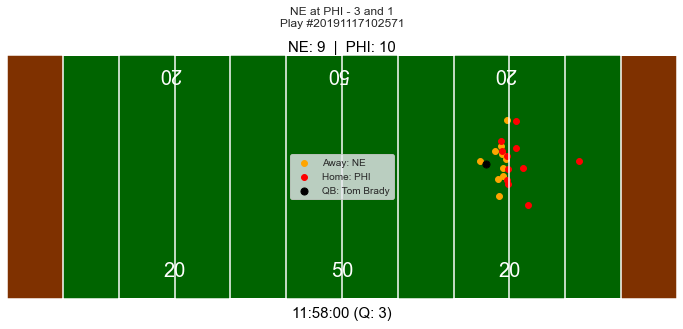

In [31]:
# Example Play
play = 20191117102571
fig, ax = plot_football_field()
plot_play(play, fig, ax)

<h3>Other Visualizations</h3>

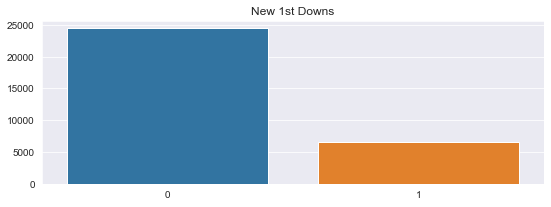

In [32]:
plt.figure(figsize=(9,3))
a = df['new1st_down'].value_counts().to_frame('New 1st Downs')/22
sns.barplot(x=list(a.index), y=list(a['New 1st Downs']))
plt.title("New 1st Downs");

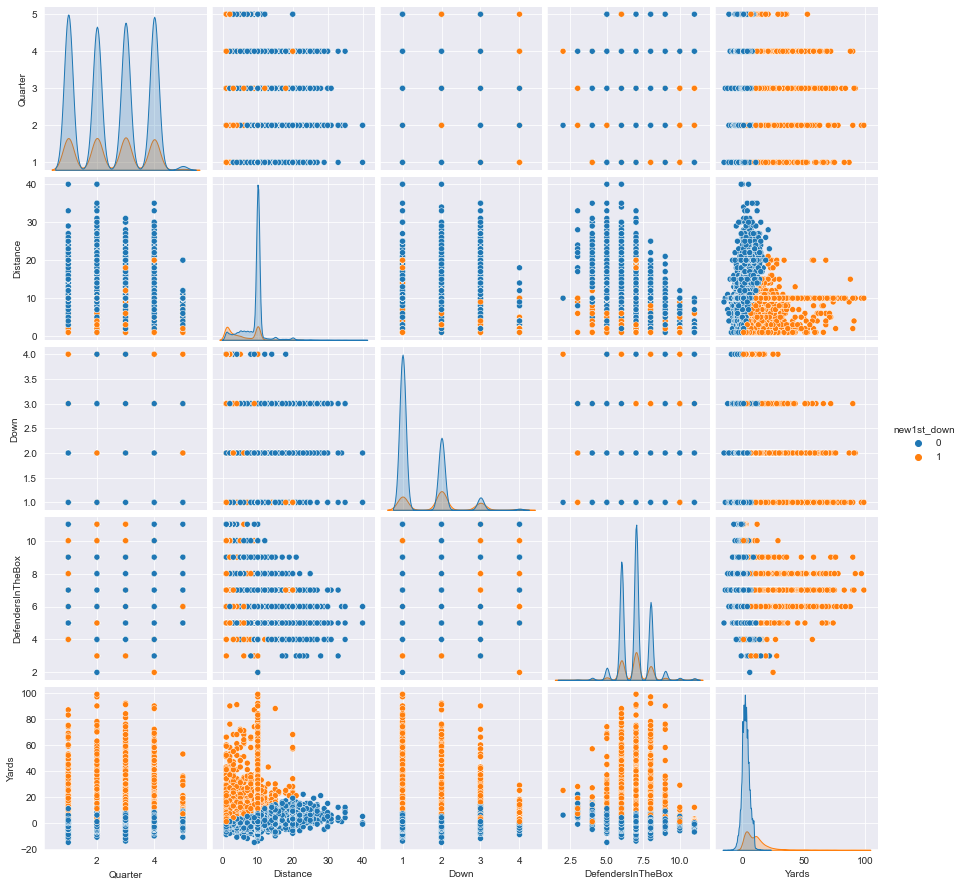

In [33]:
features = ['Quarter', 'Distance', 'Down', 'DefendersInTheBox', 'Yards', 'new1st_down']
a = df.drop_duplicates(subset=['PlayId'])
sns.pairplot(a[features], hue="new1st_down");

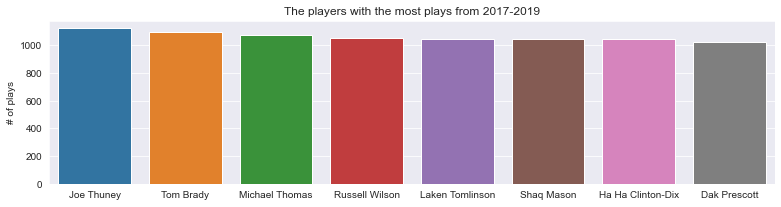

In [34]:
# Players with most plays
plt.figure(figsize=(13,3))
a = df['DisplayName'].value_counts(ascending=False).to_frame('Number of Plays')[:8]
sns.barplot(x=list(a.index), y=list(a['Number of Plays']))
plt.title('The players with the most plays from 2017-2019')
plt.ylabel('# of plays');

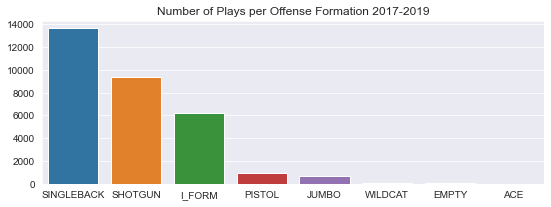

In [35]:
plt.figure(figsize=(9,3))
a = df['OffenseFormation'].value_counts(ascending=False).to_frame('Offense Formations')/22
sns.barplot(x=list(a.index), y=list(a['Offense Formations']))
plt.title('Number of Plays per Offense Formation 2017-2019');

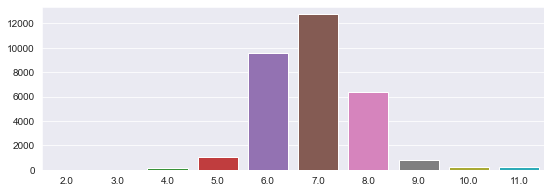

In [36]:
plt.figure(figsize=(9,3))
a = df['DefendersInTheBox'].value_counts().to_frame('DefendersInTheBox')/22
sns.barplot(x=list(a.index), y=list(a['DefendersInTheBox']));

<Figure size 648x216 with 0 Axes>

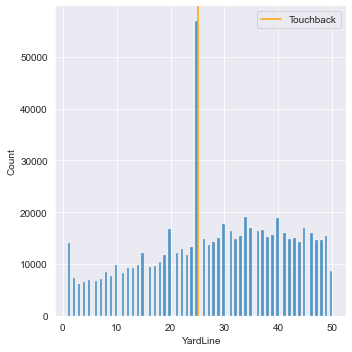

In [37]:
plt.figure(figsize=(9,3))
sns.displot(df['YardLine'])
plt.axvline(x=25, color="orange", label='Touchback')
plt.legend();

In [38]:
# List the home teams with the highest average yard gain per play
df.groupby(['HomeTeamAbbr', 'Season'], as_index=False).mean().sort_values(by='Yards', ascending=False)[['HomeTeamAbbr', 'Yards', 'Season']][:10]

HomeTeamAbbr     Yards  Season
8           BAL  5.333333    2019
13          CAR  5.184713    2018
14          CAR  5.129464    2019
86           SF  5.034130    2019
82          SEA  5.017157    2018
47           KC  4.995434    2019
22          CLE  4.867021    2018
35           GB  4.856164    2019
49           LA  4.829132    2018
19          CIN  4.808219    2018

In [39]:
# List the visitor teams with the highest average yard gain per play
df.groupby(['VisitorTeamAbbr', 'Season'], as_index=False).mean().sort_values(by='Yards', ascending=False)[['VisitorTeamAbbr', 'Yards', 'Season']][:10]

VisitorTeamAbbr     Yards  Season
44             JAX  5.619718    2019
49              LA  5.286445    2018
46              KC  5.257310    2018
38             HOU  5.254386    2019
23             CLE  5.230769    2019
28             DEN  4.965054    2018
52             LAC  4.952778    2018
14             CAR  4.947955    2019
55             MIA  4.940701    2018
4              ATL  4.902141    2018

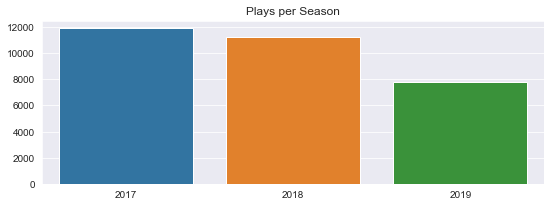

In [40]:
plt.figure(figsize=(9,3))
a = df['Season'].value_counts().to_frame('Plays per Season')/22
sns.barplot(x=list(a.index), y=list(a['Plays per Season']))
plt.title("Plays per Season");